<table width=100%>
<tr>
<td width=100%>
<h1><b>Master in Computer Vision - M6</b></h1>
<h2><b>Motion examples</b></h2>
<br>
<h4>Ayan Banerjee under supervision of Josep Ramon Morros
<br>
<a href="https://imatge.upc.edu/web/"> GPI @ IDEAI</a> Research group
</h4>
</td>
</tr>
</table>

# Motion compensation
Lets take the reference image in the example from the slides, and its motion vectors and cnstruct the compensated image:

In [1]:
import numpy as np
import pprint as pp

# Reference image
ref_ima = [[44,55,37],[21,22,60],[31,44,25]]

# Optical flow
of_x = [[0,1,-1], [2,-1,-1], [0,0,0]]
of_y = [[0,0,0], [1,1,1],[-1,-1,-1]]

print (np.array(ref_ima))


[[44 55 37]
 [21 22 60]
 [31 44 25]]


In [2]:
# Compensated image
comp_ima = np.zeros((3,3))

# Forward compensation
for ii in range(3):
    for jj in range(3):
        comp_ima[ii+of_y[ii][jj], jj+of_x[ii][jj]] = ref_ima[ii][jj]

print (comp_ima)

[[44. 37. 55.]
 [31. 44. 25.]
 [22. 60. 21.]]


# Parametric motion models examples

Download the file of_comp.zip that you will find at the virtual campus and upload it here using the menu on the left (click the folder icon, upload the file). Wait until the upload is complete, it may take a long time

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from flow_vis import flow_to_color

In [4]:
from of_comp.code.display_images import display_image, display_images

Define an object in an image (square white box)

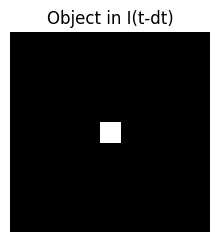

In [5]:
# Define an image with an object (square box)
ima1 = np.zeros((200,200), dtype=np.uint8)
ima1[90:111,90:111] = 255

display_image(ima1, 'Object in I(t-dt)', size = 1.0)

## Traslational motion model


Define the model parameters. The object will move 10 pixels down, 25 pixels right

In [6]:
# Traslation vector
b = np.array([10,25])

Apply the traslational model to the object:

/Users/ayanbanerjee/Documents/m6/notes/of_comp/code/display_images.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


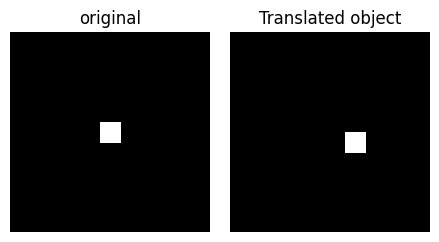

In [7]:
# Create empty image
ima2 = np.zeros_like(ima1)

for ii in range(0,ima1.shape[0]):
    for jj in range(0,ima1.shape[1]):
        pt  = np.array([ii,jj])

        # Check that the pixel belongs to the object
        if ima1[ii,jj] == 255:
            dst = pt + b
            dst = dst.astype(int)

            # Check destination is within image borders
            if dst[0] >= 0 and dst[0] < ima2.shape[0] and dst[1] >= 0 and dst[1] < ima2.shape[1]:
                ima2[dst[0], dst[1]] = ima1[pt[0], pt[1]]

display_images(ima1, ima2, 'original', 'Translated object', size=1.0)

We can define a function to obtain the motion vectors. For simplicity, it is not a true motion estimation process, we simply assume that all the pixels of the object move with the same translational motion. 

In [8]:
def traslational_flow_from_params(params, ima, only_object=False):
    h, w = ima.shape[0:2]

    if only_object == True:
        mask = np.zeros_like(ima1)
        mask[ima1 > 0] = 1
    else:
        mask = np.ones_like(ima1)
    
    of_u = np.full_like(ima1, params[0])
    of_v = np.full_like(ima1, params[1])

    of_u = of_u * mask
    of_v = of_v * mask

    return np.stack([of_u, of_v], axis=2).astype(np.float32)

We can obtain the optical flow (for each object point) by applying the transformation to the object:

In [9]:
tras_of = traslational_flow_from_params(b, ima1, only_object=True)

To visualize the optical flow, we can use a color based encoding (from package flow_vis). 

In [10]:
# Create the optical flow color encoding legend
def flow_with_legend(of):
    h,w = of.shape[0:2]
    wsize = np.array([2*max(h,w)+1, 2*max(h,w)+1], dtype=int)
    wheel = np.zeros(wsize, dtype=np.float32)

    xpos = np.array([np.arange(wsize[1]),]*wsize[0], dtype=np.float32)   - wsize[1]/2
    ypos = np.array([np.arange(wsize[0]),]*wsize[1], dtype=np.float32).T - wsize[0]/2

    mvects = np.stack([xpos,-ypos], axis=2)
    modulus = np.sqrt(xpos*xpos + ypos*ypos)
    modulus = modulus / modulus[0,wsize[0]//2]

    mask_wheel = np.zeros(wsize, dtype=np.float32)
    mask_wheel[modulus <=1] = 1
    mask_wheel = np.stack([mask_wheel,mask_wheel],axis=2)

    # Generate the legend image
    of_legend = flow_to_color(mvects*mask_wheel, convert_to_bgr=True)

    # Encode the flow using the color representation
    cc = flow_to_color(of, convert_to_bgr=True)


    plt.figure(figsize=(6, 4))
    G = gridspec.GridSpec(2, 3)
    axes_1 = plt.subplot(G[:, 0:2])
    axes_1.imshow(cc)
    axes_1.set_title('Optical Flow')

    axes_2 = plt.subplot(G[:, 2])
    axes_2.imshow(of_legend, extent=[-wsize[0]/2, wsize[0]/2, wsize[0]/2, -wsize[0]/2])
    axes_2.set_title ('Color code')

    plt.tight_layout()

    plt.show()


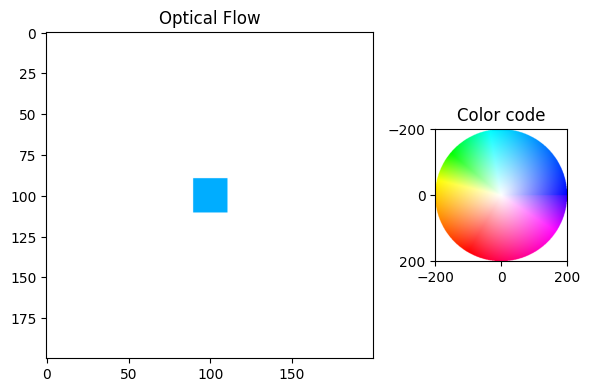

In [11]:
#cc = flow_to_color(of, convert_to_bgr=True)
#plt.imshow(cc)
flow_with_legend(tras_of)

## Affine motion model

Define the model parameters. The output will be:

```
x' = M11*x + M12*y + M13
y' = M21*x + M22*y + M23
```

In [12]:
# Affine model. Define the direct transformation matrix
Md = np.array([[ -1.06065,   0.7071,  167.1745 ],
               [  1.06065,   0.7071,  -87.3815 ]])

print (Md)

[[ -1.06065   0.7071  167.1745 ]
 [  1.06065   0.7071  -87.3815 ]]


Apply the affine model to the object. Note the holes in the result.

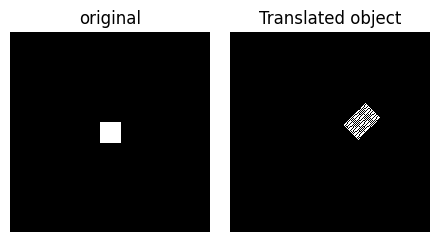

In [13]:
# Create empty image
ima2 = np.zeros_like(ima1)

for ii in range(0,ima1.shape[0]):
    for jj in range(0,ima1.shape[1]):

        # Check that the pixel belongs to the object
        if ima1[ii,jj] == 255:
            dst_x = Md[0,0]*jj + Md[0,1]*ii + Md[0,2]
            dst_y = Md[1,0]*jj + Md[1,1]*ii + Md[1,2]
            dst   = np.array([dst_y, dst_x]).astype(int)

            dst = dst.astype(int)

            # Check destination is within image borders
            if dst[0] >= 0 and dst[0] < ima2.shape[0] and dst[1] >= 0 and dst[1] < ima2.shape[1]:
                ima2[dst[0], dst[1]] = ima1[ii, jj]

display_images(ima1, ima2, 'original', 'Translated object', size=1.0)

Backward compensation. To find the inverse transform, we have to invert matrix Md. As the matrix is not square, a row at the bottom with ```[0.0, 0.0, 1.0]``` is added before inverting, and then the last row of the inverted matrix is discarded.

In [14]:
hh = np.array([[0.0, 0.0, 1.0]])

# Inverse transformation matrix for the backward compensation
Md3 = np.concatenate ([Md,hh], axis=0)
Mi = np.linalg.inv(Md3)[0:2,:]

print ('Original matrix in homogeneous coordinates')
print (Md3)
print ('Invertex transformation matrix')
print (Mi)
print ('--------------------------------')


Original matrix in homogeneous coordinates
[[ -1.06065   0.7071  167.1745 ]
 [  1.06065   0.7071  -87.3815 ]
 [  0.        0.        1.     ]]
Invertex transformation matrix
[[ -0.47140904   0.47140904 120.        ]
 [  0.70711356   0.70711356 -56.42271249]]
--------------------------------


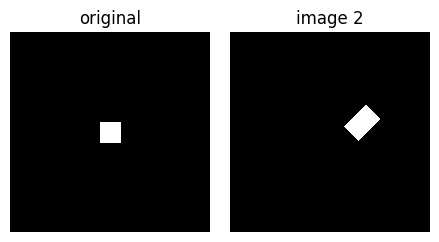

In [15]:
# Create empty image
ima2 = np.zeros_like(ima1)

for ii in range(0,ima1.shape[0]):
    for jj in range(0,ima1.shape[1]):
        ori_x = Mi[0,0]*jj + Mi[0,1]*ii + Mi[0,2]
        ori_y = Mi[1,0]*jj + Mi[1,1]*ii + Mi[1,2]
        ori   = np.array([ori_y, ori_x]).astype(int)

        if ori[0] >= 0 and ori[0] < ima1.shape[0] and ori[1] >= 0 and ori[1] < ima1.shape[1]:
            ima2[ii, jj] = ima1[ori[0], ori[1]]

display_images(ima1, ima2, 'original', 'image 2', size=1.0)

Observe that there are no holes in the backward compensation.

In [16]:
def affine_flow_from_params(params, ima, only_object=False):
    h, w = ima.shape[0:2]

    xpos = np.array([np.arange(w),]*h, dtype=np.float32)
    ypos = np.array([np.arange(h),]*w, dtype=np.float32).T

    of_u = (params[0,0]*xpos + params[0,1]*ypos + params[0,2] * np.ones_like(xpos)) - xpos
    of_v = (params[1,0]*xpos + params[1,1]*ypos + params[1,2] * np.ones_like(ypos)) - ypos

    if only_object == True:
        mask = np.zeros_like(ima1)
        mask[ima1 > 0] = 1
    else:
        mask = np.ones_like(ima1, dtype=float32)

    of_u = of_u * mask
    of_v = of_v * mask

    return np.stack([of_u,of_v], axis=2).astype(np.float32)

We can obtain the optical flow (for each object point) by applying the transformation to the object:

In [17]:
affine_of = affine_flow_from_params(Md, ima1, only_object=True)

Visualize the optical flow:

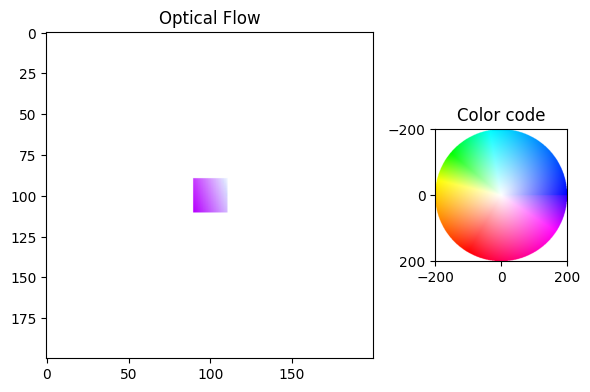

In [18]:
flow_with_legend(affine_of)

Visualize (some of) the motion vectors:

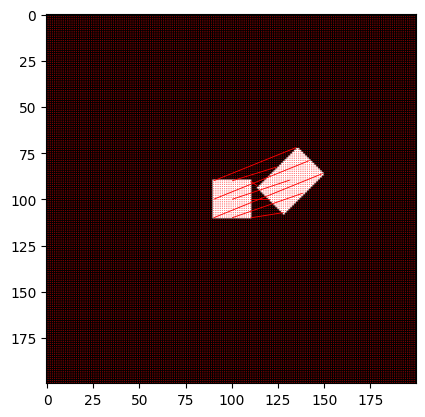

In [19]:
X = np.arange(0, affine_of.shape[1], 1)
Y = np.arange(0, affine_of.shape[0], 1)
x,y = np.meshgrid(X,Y)

# Points over the object
Xo = np.arange(90, 111, 10)
Yo = np.arange(90, 111, 10)
xo,yo = np.meshgrid(Xo,Yo)

U = np.zeros(affine_of.shape[0:2])
V = np.zeros(affine_of.shape[0:2])

U[90:111:10, 90:111:10] = affine_of[90:111:10, 90:111:10, 0]
V[90:111:10, 90:111:10] = affine_of[90:111:10, 90:111:10, 1]
plt.imshow(np.logical_or(ima1,ima2))
plt.quiver(X, Y, U, V, color = 'r', angles='xy', scale_units='xy', scale=1,
               pivot = 'tail', headwidth=1, headlength =2)